In [2]:
from optimization_linear import *
from utils import *
from get_acc import *
import os
#os.chdir('./ezVSys')
print(os.getcwd())

/home/ob3942/scripts/adv_cv


In [3]:
def getData(config, robot_idx, isnotTestData=True):
    """ A function to get the data for each robot with the hardness levels that this robot is operating on

    Args:
        config: a configuration file containing the all information regarding the experiment
        robot_idx: the index of a robot
        isnotTestData (bool, optional): Whether the output dataset will be used to evaluate the utility or to be used by robots for training/inference. Defaults to True.

    Returns:
        The output dataset
    """
    robots_envs_x=[]
    robots_envs_y=[]
    for robot in robot_idx:
        if isnotTestData:
            hardness =  config['hardness_levels'][robot,0]
            robot_x = np.load(config['dataset_path']+'mnist_train_data_env_hardness_'+str(hardness)+'.npy')
            robot_y = np.load(config['dataset_path']+'mnist_train_labels_env_hardness_'+str(hardness)+'.npy')
        else:
            robot_x = np.load(config['dataset_path']+'mnist_train_data_env_hardness_'+'testEnvironment'+'.npy')
            robot_y = np.load(config['dataset_path']+'mnist_train_labels_env_hardness_'+'testEnvironment'+'.npy')
        robots_envs_x.append(robot_x)
        robots_envs_y.append(robot_y)

        robot_x= np.array([])
        robot_y = np.array([])
    
    return robots_envs_x, robots_envs_y

In [4]:
# An experiment showing that for increasing environmental hardness level and for a fixed robot accuracy, the utility is a concave function as our theory provides.

# some initializations
# these tuples corresponding to the table given in the paper. Each robot operating on environments with different hardness levels have different final accuracy after training. This arrays gives these maps.
# Each robot tuple corresponds to different accuracy levels in each environment.
robot_tuples1 = [ (0.001, 90), (0.01, 89), (0.1, 91), (0.2, 89), (0.3, 92), (0.4,89), (0.5,88), (0.6,88), (0.7, 87), (0.8, 84)]
robot_tuples2 = [ (0.001, 79), (0.01, 79), (0.1, 81), (0.2, 80), (0.3, 80), (0.4,81), (0.5,79), (0.6,80), (0.7, 82), (0.8, 79)]
robot_tuples3 = [ (0.001, 69), (0.01, 70), (0.1, 71), (0.2, 69), (0.3, 69), (0.4,69), (0.5,71), (0.6,70), (0.7, 70), (0.8, 70)]
robot_tuples4 = [(0.001, 59), (0.01, 59), (0.1, 63), (0.2, 57), (0.3, 59), (0.4,61), (0.5,58), (0.6,60), (0.7, 58), (0.8, 58)]
robot_tuples5 = [(0.001, 51), (0.01, 51), (0.1, 48), (0.2, 50), (0.3, 48), (0.4,48), (0.5,50), (0.6,53), (0.7, 48), (0.8, 49)]
robot_tuples6 = [(0.001, 35), (0.01, 39), (0.1, 33), (0.2, 36), (0.3, 36), (0.4,35), (0.5,34), (0.6,33), (0.7, 31), (0.8, 32)]
output_utils = []
all_robots = [robot_tuples1, robot_tuples2, robot_tuples3, robot_tuples4, robot_tuples5, robot_tuples6 ]

# iterate over different accuracies
for itr_robot in all_robots:
    robot_env = []
    robot_sim_accs = []
    for i in itr_robot:
        a,b = i
        robot_env.append(a)
        robot_sim_accs.append(b)
    robot_sim_accs = np.asarray(robot_sim_accs)
    robot_env = np.asarray(robot_env)

    robotnum = 1 # the number of robot used in the experiment. Since we only care about the utility value for increasing hardness level there is no incentive to investigate multirobot effects in this experiment
    method = 'cvx'# this is our resource allocation mechanism, others are uniform and random
    model = MNIST_model.MNISTClassifier().to('cuda:0')
    robot_idx = np.arange(robotnum)
    cloud_hardness = [0.8] # cloud model should be the best model on hardes env
    cloud_acc = [0.84] # cloud model should be the best model on hardes env
    sim_utils = []
    models_path = 'models_original/'
    cloud_model_path = 'models_original/hardness_0.8/84_25000.pt'
    robot_utilities = []
    for simnum in range(len(robot_sim_accs)):
        print('+++++++++++++++')
        print('simnum: '+str(simnum))
        exp_config ={
        'num_of_robots' : robotnum,
        'dataset_path' : 'hardEnvs/',
        'models_path' : 'original_models/',
        'all_hardness_levels' : np.array([0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1]),
        'all_model_accs' : np.array([35, 50, 61, 70, 81, 90, 92]),
        'testDatasetSize':1000,
        'cloud_resource':1000,
        'cloud_accuracy':1,
        'robot_accuracy': np.asarray([[robot_sim_accs[simnum]/100]]),
        'hardness_levels':np.asarray([[robot_env[i]] for i in range(len(robot_env))]),
        'accuracy_elasticity':0.5,
        'hardness_elasticity':0.5,
        'task_deadlines':np.asarray([[1000] for _ in range(robotnum)]),
        }

        # dataset to measure the utility is the test dataset
        robots_envs_x, robots_envs_y = getData(exp_config, robot_idx, False)

        # calculate the decision and offloading rate
        offloadingRates, objValues = utilityMax(exp_config, exp_config['num_of_robots'])
        print(np.shape(offloadingRates))
        offloadingRates = np.array([[0]])
        #offloadingRates =[[0]]
        # print theoretical utilities
        vecObjVals = rate2utility(exp_config['cloud_accuracy'], exp_config['robot_accuracy'], offloadingRates, exp_config['hardness_levels'])    
        print('utility vec')
        print(vecObjVals)
        # get the images that will be offloaded
        samples_to_offload = np.int32(np.round(offloadingRates*exp_config['testDatasetSize'])) 
        print('num samples to offload: '+str(samples_to_offload))

        offloaded_images = [[] for i in range(exp_config['num_of_robots']) ]
        for robot in robot_idx:
            offloaded_images[robot]=(robots_envs_x[robot][:samples_to_offload[robot,0]])

        # try for different accuracies and plot the test performance

        # get the labels from the cloud     
        model.load_state_dict(torch.load(cloud_model_path))
        cloud_inference = [[] for i in range(exp_config['num_of_robots'])]
        for robot in robot_idx:
            if samples_to_offload[robot,0]:
                labels = getlabels(offloaded_images[robot],model)
                cloud_inference[robot].append(labels)

        # get the inference from the local models
        localInferenceLabels = [[] for i in range(exp_config['num_of_robots'])]
        for robot in robot_idx:
            if exp_config['testDatasetSize']-samples_to_offload[robot,0]:
                X = robots_envs_x[robot][samples_to_offload[robot,0]:]
                model = MNIST_model.MNISTClassifier().to('cuda:0')
                # #########################################################
                print(robot_env[simnum])
                print(robot_sim_accs[simnum])
                prefixed = [filename for filename in os.listdir(models_path+'hardness_'+str(robot_env[simnum])) if filename.startswith(str(robot_sim_accs[simnum]))]
                model.load_state_dict(torch.load(models_path+'hardness_'+str(robot_env[simnum])+'/'+prefixed[0]))
                localInferenceLabels[robot].append(np.asarray(getlabels(X,model)))

        # for each robot calculate the measured utility and thus mean of the robot utilities
        
        for robot in robot_idx:
            original_labels = robots_envs_y[robot][:]
            
            if len(cloud_inference[robot]):
                cloud_contribution = cloud_inference[robot][0]
            else:
                cloud_contribution = np.zeros((0,1))
            
            if len(localInferenceLabels[robot]):
                local_contribution = localInferenceLabels[robot][0]
            else:
                local_contribution = np.zeros((0,1))

            predictions = np.squeeze(np.concatenate([np.asarray(cloud_contribution), np.asarray(local_contribution)]))
            
            print('predictions shape'+str(np.shape(predictions)))
            utility = np.sum(np.squeeze(original_labels)==predictions)/len(original_labels)
            print('utility for robot ' + str(robot) + ': ' + str(utility))
            robot_utilities.append(utility)
            
    # ut = [np.mean(np.array(sim_utils[i])) for i in range(len(sim_utils))]
    # np.save('utilvsaccMNIST_'+method+'.npy', np.asarray(ut))
    print(robot_utilities)
    output_utils.append(robot_utilities)

+++++++++++++++
simnum: 0
Rates: 
[[1.]]
Total Utility: 
5.288032894722935
(1, 1)
utility vec
[[0.03      ]
 [0.09486833]
 [0.3       ]
 [0.42426407]
 [0.51961524]
 [0.6       ]
 [0.67082039]
 [0.73484692]
 [0.79372539]
 [0.84852814]]
num samples to offload: [[0]]
0.001
90
predictions shape(1000,)
utility for robot 0: 0.215
+++++++++++++++
simnum: 1
Rates: 
[[1.]]
Total Utility: 
5.288032894507651
(1, 1)
utility vec
[[0.02983287]
 [0.09433981]
 [0.29832868]
 [0.42190046]
 [0.51672043]
 [0.59665736]
 [0.6670832 ]
 [0.73075304]
 [0.78930349]
 [0.84380092]]
num samples to offload: [[0]]
0.01
89
predictions shape(1000,)
utility for robot 0: 0.296
+++++++++++++++
simnum: 2
Rates: 
[[1.]]
Total Utility: 
5.288032894937605
(1, 1)
utility vec
[[0.03016621]
 [0.09539392]
 [0.30166206]
 [0.42661458]
 [0.52249402]
 [0.60332413]
 [0.67453688]
 [0.73891813]
 [0.7981228 ]
 [0.85322916]]
num samples to offload: [[0]]
0.1
91
predictions shape(1000,)
utility for robot 0: 0.471
+++++++++++++++
simnum: 3

In [5]:
print("Calculated utility values for increasing hardness levels for a fixed accuracy level. This values will be plotted in the following cells.")
print(output_utils)

Calculated utility values for increasing hardness levels for a fixed accuracy level. This values will be plotted in the following cells.
[[0.215, 0.296, 0.471, 0.703, 0.781, 0.835, 0.843, 0.893, 0.922, 0.91], [0.257, 0.217, 0.519, 0.549, 0.736, 0.737, 0.79, 0.842, 0.883, 0.893], [0.2, 0.216, 0.451, 0.461, 0.6, 0.639, 0.713, 0.759, 0.791, 0.823], [0.198, 0.178, 0.303, 0.44, 0.497, 0.563, 0.607, 0.634, 0.677, 0.734], [0.178, 0.182, 0.185, 0.436, 0.391, 0.465, 0.486, 0.576, 0.58, 0.61], [0.168, 0.149, 0.207, 0.268, 0.308, 0.284, 0.35, 0.374, 0.347, 0.371]]


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

DEBUG:matplotlib:matplotlib data path: /home/ob3942/Anaconda/envs/col_inf_py/lib/python3.10/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/home/ob3942/.config/matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:CACHEDIR=/home/ob3942/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/ob3942/.cache/matplotlib/fontlist-v330.json
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


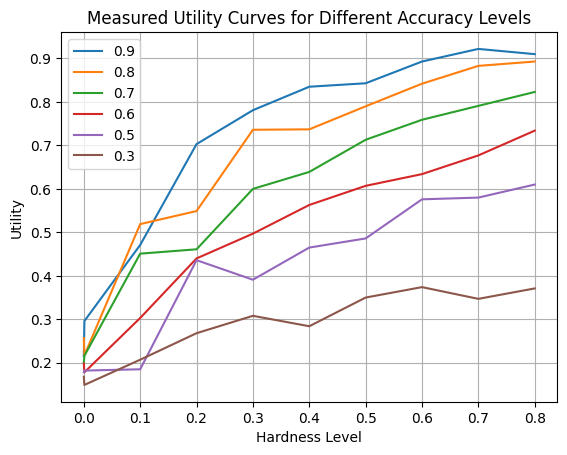

In [9]:
plt.plot([0, 0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],np.transpose(np.asarray(output_utils)))
plt.xlabel("Hardness Level")
plt.ylabel("Utility")
plt.grid()
plt.title("Measured Utility Curves for Different Accuracy Levels")
plt.legend([0.9, 0.8, 0.7, 0.6, 0.5, 0.3])